# Cardiomyocyte Content Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## Introduction

Stem cell-derived cardyomyocytes (CM) have great potential for ischemic heart disease treatment. For their in-vitro production, hPSC (human pluripotent stem cells) must differentiate into hPSC-CM. 

*Threshold for classification is CM content >= 90 is sufficient and < 90 is insufficient (add to this later with source from paper)

### Main questions:
#### Can the sufficiency of CM content be accurately predicted?
#### Which features are most influential in high CM content?

In [2]:
# Importing data
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
# Ensuring both datasets have same number of features
assert len(train_df.columns) == len(test_df.columns)
# Combining both datasets
data = pd.concat([train_df, test_df], ignore_index=True)

In [3]:
# Adding sufficiency column to data; CM content >= 90 is sufficinet; < 90 is insufficient
data["CM Content Sufficiency"] = 0
# 1 is sufficient, 0 is insufficient
for i in data.index:
    if data.loc[i, "dd10 CM Content"] >= 90:
        data.loc[i, "CM Content Sufficiency"] = 1
    else:
        data.loc[i, "CM Content Sufficiency"] = 0

In [4]:
# The dd10 CM Content column is no longer needed
data.drop("dd10 CM Content", axis=1, inplace=True)

#### New train and test sets will be made later to ensure a random split

## Data Cleaning

After visual inspection, the "DO concentration/cell count dd7" and "DO gradient/cell count dd7" columns in the test file did not have proper references to the cell count cells resulting in #ref errors. This has been fixed in the test excel file and converted back to csv.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 103 entries, dd0 Cell Density to CM Content Sufficiency
dtypes: float64(102), int64(1)
memory usage: 48.4 KB


In [6]:
data.isna().sum().sum()

0

There are now no missing values in the dataset. All data types are numerical (float64 or int64).

## Feature Selection and Cross Validation

Before feature selection, the data will be split into train and test sets. This is done before feature selection to avoid picking features based on test (unseen) data

In [7]:
# Dividing data into X and y sets and splitting into train and test sets
from sklearn.model_selection import train_test_split
X = data.drop('CM Content Sufficiency', axis=1)
y = data['CM Content Sufficiency']
# The stratify argument ensures the proportion of each class in the train and test sets is reflective of the
# original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=25)

We have 102 features and only 60 observations. The number of features needs to be dramatically reduced to avoid
overfitting. With a large number of features compared to observations, the model will fit the noise in the training set leading to poor generalization.

The recursive feature elimination technique will be combined with cross validation using Scikit learn's RFECV. Recursive feature elimination iteratively considers less and less features by fitting the model at each step and discarding the least important ones.

In cross-validation (cv), the training set is further split into n subsets. The model is then trained on a fraction of each subset and evaluated on the remaining fraction. This is done n times for each subset. The cv performance is the average evaluated performance across each of the subsets.

Combining rfe and cv allows reducing the risk of overfitting (thanks to cv) while reliably identifying the important features. Cv helps make the feature selection task more robust, as the selected features have proven to be important across different subsets of the data.

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
lg = LogisticRegression(solver='liblinear')
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=25)
rfecv = RFECV(lg, cv=kf, scoring='recall')
rfecv.fit(X_train, y_train)
rfecv.n_features_
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 5


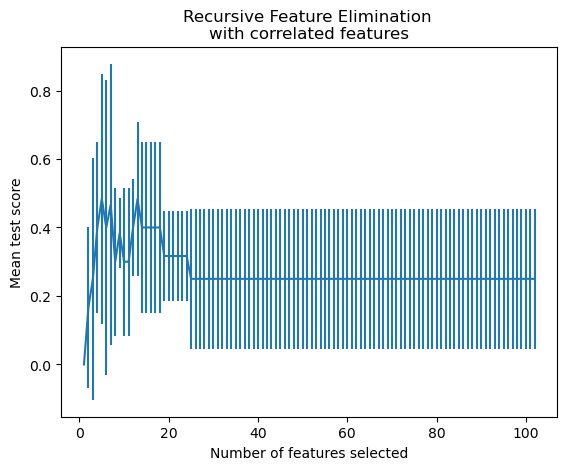

In [12]:
# Visualizing model performance as number of features changes
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## Using their train and test sets

In [16]:
# Adding sufficiency column to data; CM content >= 90 is sufficinet; < 90 is insufficient
train_df["CM Content Sufficiency"] = 0
test_df["CM Content Sufficiency"] = 0
dfs = [train_df, test_df]
# 1 is sufficient, 0 is insufficient
for df in dfs:
    for i in df.index:
        if df.loc[i, "dd10 CM Content"] >= 90:
            df.loc[i, "CM Content Sufficiency"] = 1
        else:
            df.loc[i, "CM Content Sufficiency"] = 0
    # dd10 CM Content column is no longer needed
    df.drop("dd10 CM Content", axis=1, inplace=True)

In [21]:
prop = len(test_df[test_df["CM Content Sufficiency"] == 1]) / len(test_df)
prop

0.2777777777777778

In [22]:
prop_tr = len(train_df[train_df["CM Content Sufficiency"] == 1]) / len(train_df)
prop_tr

0.3333333333333333